In [1]:
import os
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import math
import pywt
import scipy.signal as signal
from scipy.integrate import cumtrapz

# Actigraph IMU CSV Pre-processing

In [3]:
file = "TAS1F51160037 (2022-04-18)-IMU.csv"
name = file.strip(".csv")
raw_df = pd.read_csv(file, skiprows=10, header=0)
colnames_dict = {"Timestamp": "timestamps","Accelerometer X": "accel_x",
                 "Accelerometer Y": "accel_y","Accelerometer Z": "accel_z",
                 "Gyroscope X": "gyro_x","Gyroscope Y": "gyro_y", 
                 "Gyroscope Z": "gyro_z","Magnetometer X": "magnet_x",
                 "Magnetometer Y": "magnet_y","Magnetometer Z": "magnet_z"}
raw_df.rename(columns=colnames_dict, inplace = True)
# add unix timestamps
raw_df['unix_timestamps'] = pd.to_datetime(raw_df.timestamps, format="%Y-%m-%dT%H:%M:%S.%f").values.astype(np.int64) // 10**6
# Save results to CSV
processed_file = f'dwight_ankle100hz_2022-4-18_filtered.csv'
# processed_file = "dwight_waist100hz_GYRO_2021-11-21.csv" # for example purposes
# view input data
raw_df.head()

,timestamps,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,unix_timestamps
0,2022-04-16T14:00:00.0000000,1.033203,-0.062012,-0.136719,-10.437012,11.657716,-31.066896,1650117600000
1,2022-04-16T14:00:00.0100000,1.046416,-0.062847,-0.126816,-7.849732,15.230103,-35.136721,1650117600010
2,2022-04-16T14:00:00.0200000,1.049023,-0.048301,-0.113252,-5.451660,18.487550,-39.320071,1650117600020
3,2022-04-16T14:00:00.0300000,1.034434,-0.021406,-0.111611,-3.381348,21.252443,-43.052981,1650117600030
4,2022-04-16T14:00:00.0400000,1.027031,0.014063,-0.105176,-2.180176,23.713380,-45.842288,1650117600040


In [6]:
# Save results to local directory
raw_df.to_csv(processed_file,index=False)

# TURN DETECTION From Gyro Data
USING ALGORITHM FROM https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3926561/

In [313]:
## if you want to load specific file run this block
file = "dwight_waist100hz_2022-04-18_filtered.csv" # for example purposes, substitute in lines below
processed_file = file

In [314]:
name = processed_file.strip(".csv")
gyro_df = pd.read_csv(processed_file)
gyro_df.head()

,timestamps,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,unix_timestamps
0,2022-04-16T14:00:00.0000000,0.085449,-0.935059,0.282227,1.708984,-40.405276,32.287600,1650117600000
1,2022-04-16T14:00:00.0100000,0.057080,-0.966089,0.267544,-1.061401,-38.230593,32.148439,1650117600010
2,2022-04-16T14:00:00.0200000,0.101455,-0.992813,0.264014,-3.409424,-40.488284,30.401613,1650117600020
3,2022-04-16T14:00:00.0300000,0.144980,-0.999365,0.256294,-2.868042,-41.489871,27.611086,1650117600030
4,2022-04-16T14:00:00.0400000,0.176426,-0.994102,0.238379,1.225586,-39.077151,24.318849,1650117600040


### Filter and Visualize Input Signal

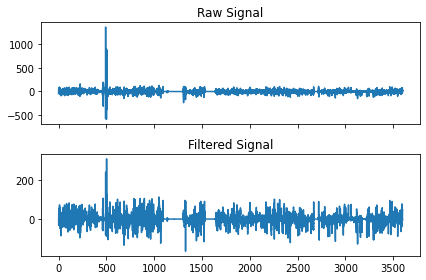

In [315]:
# extract vertical component of angular velocity
sig = gyro_df['gyro_y']
# apply 1.5Hz 4th order Butterworth filter
order = 4
filter_freq = 1.5
sampling_freq = 100
sos = signal.butter(N=order, Wn=filter_freq, fs = sampling_freq, 
                     btype='lowpass', analog=False, output="sos")
filtered = signal.sosfilt(sos, sig)
# transform time to 0 and rescale to seconds from ms
time = (gyro_df['unix_timestamps'] - min(gyro_df['unix_timestamps']))/1000

# plot the raw and filtered signals
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
ax1.plot(time, sig)
ax1.set_title("Raw Signal")
ax2.plot(time, filtered)
ax2.set_title("Filtered Signal")
plt.tight_layout()
plt.show()

### Turn Detection
Algorithm is modeled directly from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3926561/, with some parameters adjusted to better fit the Actigraph sensor input

In [316]:
# local_maxima = abs(filtered) > 15
candidate_turns = []
candidate_min_peak_mag = 15 # minimum required angular velocity peak magnitude for each candidate turn segment
turning = False
start = 0
for i in range(0, len(filtered)):
    # currently turning
    if turning:
        # check for turn end when |angular velocity| < 5
        if abs(filtered[i]) < 5:
            # add segment to candidate turn if |max angular velocity| >= 15
            if max(abs(filtered[start:i])) >= candidate_min_peak_mag:
                candidate_turns.append((start, i-1))
            turning = False
    # not turning
    else:
        # check for turn start when |angular velocity| >= 5
        if abs(filtered[i]) >= 5:
            turning = True
            start = i

# combine same-direction turns separated by < 0.05 seconds
combined_turns = [candidate_turns[0]]
for (turn_start, turn_end) in candidate_turns[1:]:
    prev_turn = combined_turns[-1]
    intra_turn_duration = time[turn_start] - time[prev_turn[1]] 
    # combine same-direction turns with intra-turn duration < 0.05s
    if intra_turn_duration < 0.05 and filtered[turn_start]*filtered[prev_turn[1]] > 0:
        combined_turns[-1] = (prev_turn[0], turn_end)
    # add current turn as separate turn instance
    else:
        combined_turns.append((turn_start, turn_end))

# keep turns within 0.5s - 10s window and >= 45 degree turn angle
final_turns = []
turn_angles = []
for (turn_start, turn_end) in combined_turns:
    # check turn duration for 0.5s - 10s
    turn_duration = time[turn_end] - time[turn_start]
    if turn_duration >= 0.5 and turn_duration <= 10:
        # check turn angle for >= 45 degrees
        # turn_angle = turn_duration*sum(abs(filtered[turn_start:turn_end+1]))
        # compute using integration
        turn_angle = cumtrapz(abs(filtered[turn_start:turn_end+1]), time[turn_start:turn_end+1], initial=0)[-1]*turn_duration
        if turn_angle >= 45:
            final_turns.append((turn_start, turn_end))
            turn_angles.append(turn_angle)

### Visualize Turns
Static and interactive plots for visualizing turns on the filtered signal

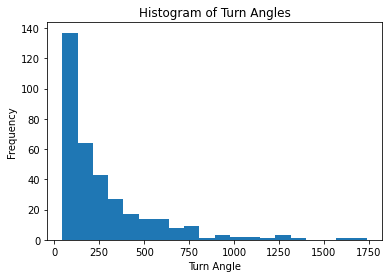

In [317]:
plt.hist(turn_angles,bins=20)
plt.title("Histogram of Turn Angles")
plt.ylabel("Frequency")
plt.xlabel("Turn Angle")
plt.show()

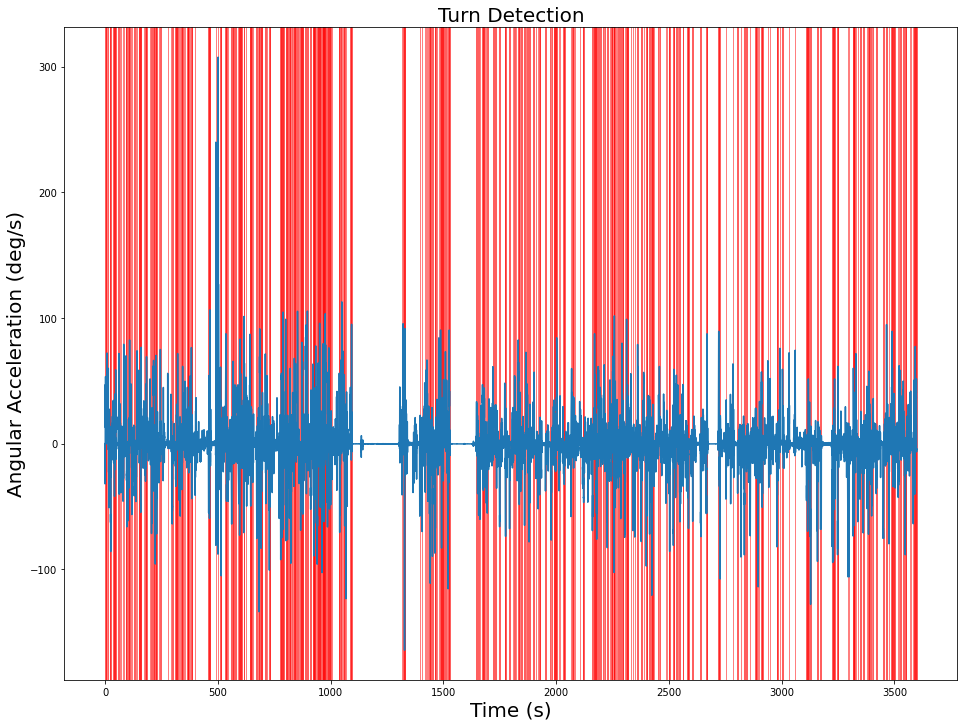

In [318]:
plt.plot(time, filtered)
plt.title("Turn Detection",fontsize=20)
plt.xlabel("Time (s)",fontsize=20)
plt.ylabel("Angular Acceleration (deg/s)",fontsize=20)
for turn_start, turn_end in final_turns:
    time_start = time[turn_start]
    time_end = time[turn_end]
    plt.axvspan(time_start, time_end, color='red', alpha=0.5)
figure = plt.gcf()
figure.set_size_inches(16,12)
#out_fig = name + "_turns.png"
#plt.savefig(out_fig, dpi=300)
plt.show()

### Make an Interactive Plot for Visualizing Turn data

In [14]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import BoxAnnotation

interactive_plot_fname = f"{name}_turns.html"
output_file(filename=interactive_plot_fname, title="Turn Analysis Plot")

# instantiating the figure object
graph = figure(title="Turn Analysis Graph",
               title_location="above",
               x_axis_label="Time (s)",
               y_axis_label="Angular Acceleration (deg/s)",
               plot_height=600,
               plot_width=900)
 
# the points to be plotted
x = time
y = filtered
 
# plotting the 1st line graph
#graph.line(x, y, legend_label="Angular Acceleration around Vertical Axis", line_color="blue")
graph.line(x, y, line_color="blue") 

# add annotation boxes for all turns
for turn_start, turn_end in final_turns:
    time_start = time[turn_start]
    time_end = time[turn_end]
    graph.add_layout(BoxAnnotation(left=time_start, right=time_end, fill_alpha=0.2, fill_color='red'))
 
# displaying the model
show(graph)

In [15]:
from bokeh.plotting import save, reset_output

# save results to html file
save(graph)
reset_output()

# Bout and Step Detection Using Gyro Data
from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3926561/

In [319]:
## if you want to load a specific file for analysis, use the following code block
file = "dwight_waist100hz_2022-04-18_filtered.csv" # for example purposes, substitute in lines below
processed_file = file
name = processed_file.strip(".csv")

In [320]:
gyro_df = pd.read_csv(processed_file)
gyro_df.head()

,timestamps,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,unix_timestamps
0,2022-04-16T14:00:00.0000000,0.085449,-0.935059,0.282227,1.708984,-40.405276,32.287600,1650117600000
1,2022-04-16T14:00:00.0100000,0.057080,-0.966089,0.267544,-1.061401,-38.230593,32.148439,1650117600010
2,2022-04-16T14:00:00.0200000,0.101455,-0.992813,0.264014,-3.409424,-40.488284,30.401613,1650117600020
3,2022-04-16T14:00:00.0300000,0.144980,-0.999365,0.256294,-2.868042,-41.489871,27.611086,1650117600030
4,2022-04-16T14:00:00.0400000,0.176426,-0.994102,0.238379,1.225586,-39.077151,24.318849,1650117600040


## Detect Bouts using Combined Rotational Data

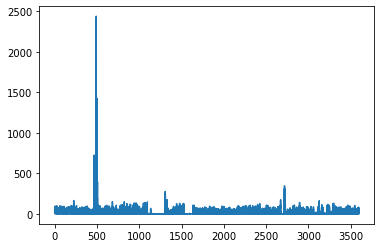

In [321]:
# calculate total rotational rate
gyro_t = np.sqrt(sum([np.square(gyro_df['gyro_x']),np.square(gyro_df['gyro_y']),np.square(gyro_df['gyro_z'])]))
# transform time to 0 and rescale to seconds from ms
time = (gyro_df['unix_timestamps'] - min(gyro_df['unix_timestamps']))/1000
plt.plot(time,gyro_t)

In [325]:
# calculate bouts using thresholding
bout_min_angular_vel = 15
candidate_bouts = []
is_bout = False
start = 0
for i in range(0, len(gyro_t)):
    # currently measuring a bout
    if is_bout:
        # check for bout end when |total angular velocity| < bout minimum threshold
        if gyro_t[i] < bout_min_angular_vel:
            candidate_bouts.append((start, i-1))
            is_bout = False
    # not a bout
    else:
        # check for turn start when |angular velocity| >= 5
        if gyro_t[i] >= bout_min_angular_vel:
            is_bout = True
            start = i

# combine candidate bouts separated by less than 2.5 seconds of activity
bout_max_seperation = 2.5
final_bouts = [candidate_bouts[0]]
for bout_start, bout_end in candidate_bouts[1:]:
    prev_bout = final_bouts[-1]
    intra_bout_duration = time[bout_start] - time[prev_bout[1]] 
    if intra_bout_duration < bout_max_seperation:
        final_bouts[-1] = (prev_bout[0], bout_end)
    else:
        final_bouts.append((bout_start, bout_end))

# eliminate bouts < 3 seconds in duration
final_bouts = [bout for bout in final_bouts if time[bout[1]]-time[bout[0]]>3.00]
print(len(final_bouts))

111


### Visualize Results

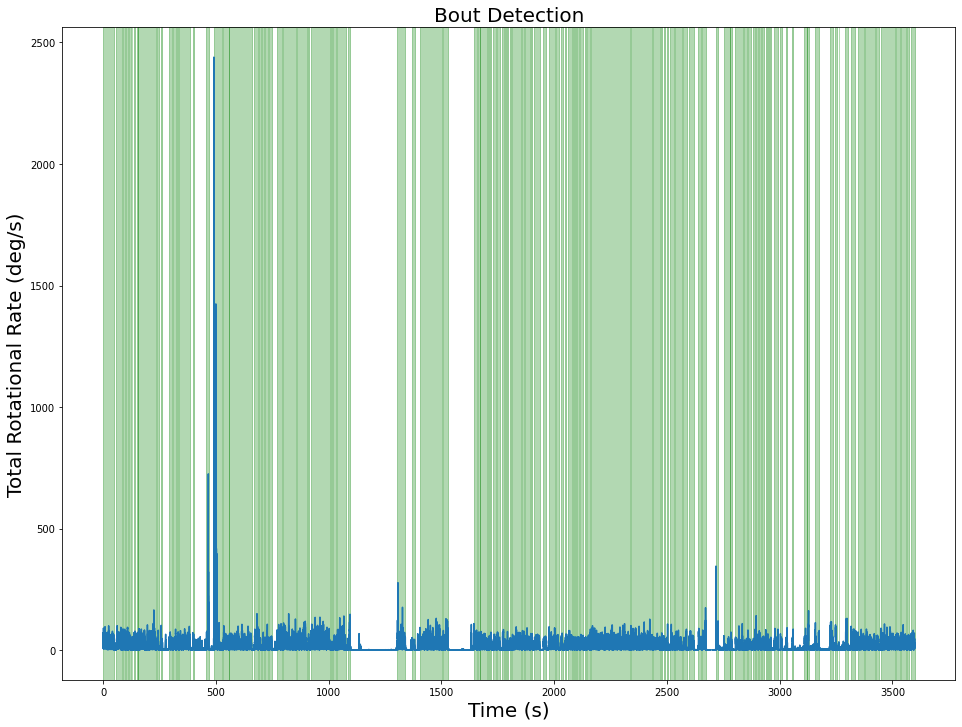

In [323]:
plt.plot(time, gyro_t)
plt.title("Bout Detection",fontsize=20)
plt.xlabel("Time (s)",fontsize=20)
plt.ylabel("Total Rotational Rate (deg/s)",fontsize=20)
for bout_start, bout_end in final_bouts:
    time_start = time[bout_start]
    time_end = time[bout_end]
    plt.axvspan(time_start, time_end, color='green',alpha=0.3)
    #plt.axvline(time_start,color='green')
    #plt.axvline(time_end,color='red') 
figure = plt.gcf()
figure.set_size_inches(16,12)
#out_fig = name + "_turns.png"
#plt.savefig(out_fig, dpi=300)
plt.show()

In [557]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import BoxAnnotation

interactive_plot_fname = f"{name}_bouts.html"
output_file(filename=interactive_plot_fname, title="Bout Detection Graph")

# instantiating the figure object
bout_graph = figure(title="Bout Detection Graph",
               title_location="above",
               x_axis_label="Time (s)",
               y_axis_label="Total Rotational Rate (deg/s)",
               plot_height=600,
               plot_width=900)
 
# the points to be plotted
x = time
y = gyro_t
 
# plotting the 1st line graph
#bout_graph.line(x, y, legend_label="Angular Acceleration around Vertical Axis", line_color="blue")
bout_graph.line(x, y, line_color="blue") 


# add annotation boxes for all turns
for bout_start, bout_end in final_bouts:
    time_start = time[bout_start]
    time_end = time[bout_end]
    bout_graph.add_layout(BoxAnnotation(left=time_start, right=time_end, fill_alpha=0.2, fill_color='red'))
 
# displaying the model
show(bout_graph)

In [495]:
# Save plot to html file
save(bout_graph)
reset_output()

## STEP DETECTION

### Algorithm 1: Use candidate bouts and signal from gyroscope to determine steps
from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3926561/

In [326]:
from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt

# choose signal for step detection
#step_signal = gyro_df['gyro_y'] # use the raw gyro data
step_signal = filtered # use the filtered gyro data

# assume maximum step cadence of 240 steps/min
max_cadence = 240
min_step_separation = 60/max_cadence # in seconds

# candidate steps
candidate_steps = {}

# select all mid-swing (peak pitch angular velocity) candidates from each bout
for (idx, (bout_start, bout_end)) in enumerate(final_bouts):
    peaks = find_peaks(step_signal[bout_start:bout_end], height=None)[0]
    #peaks = find_peaks_cwt(step_signal[bout_start:bout_end],np.arange(1,10))
    
    # remove bouts with less than 3 steps and fewer than 3 seconds in duration
    if peaks.size > 3:
        candidate_steps[idx] = peaks.tolist()

# detect steps across entire signal
'''
peaks = find_peaks(step_signal, height=None)[0]
#peaks = find_peaks_cwt(step_signal[bout_start:bout_end],np.arange(1,10))

# remove bouts with less than 3 steps and fewer than 3 seconds in duration
if peaks.size > 3:
    candidate_steps[idx] = peaks.tolist()
'''

print("Number of steps in each bout")
for step_arr in candidate_steps.values():
    print(len(step_arr))
    #print(step_arr.size)
# remove candidate steps shorter than 0.25 seconds in duration (>240 steps/min)

Number of steps in each bout
58
36
13
8
10
4
8
6
90
10
5
21
11
8
56
8
18
52
28
106
17
8
6
14
19
20
56
50
6
98
5
18
43
10
38
11
103
21
16
8
33
6
8
16
12
4
5
5
8
50
8
25
10
29
17
37
12
12
8
18
8
8
10
16
5
17
204
111
35
5
8
7
23
37
17
27
15
15
11
28
7
35
12
16
13
11
8
13
6
7
7
21
7
9
5
10
6
17
14
6
4
13
15
32
48
15
83
20
30
11
18


### Visualize Results

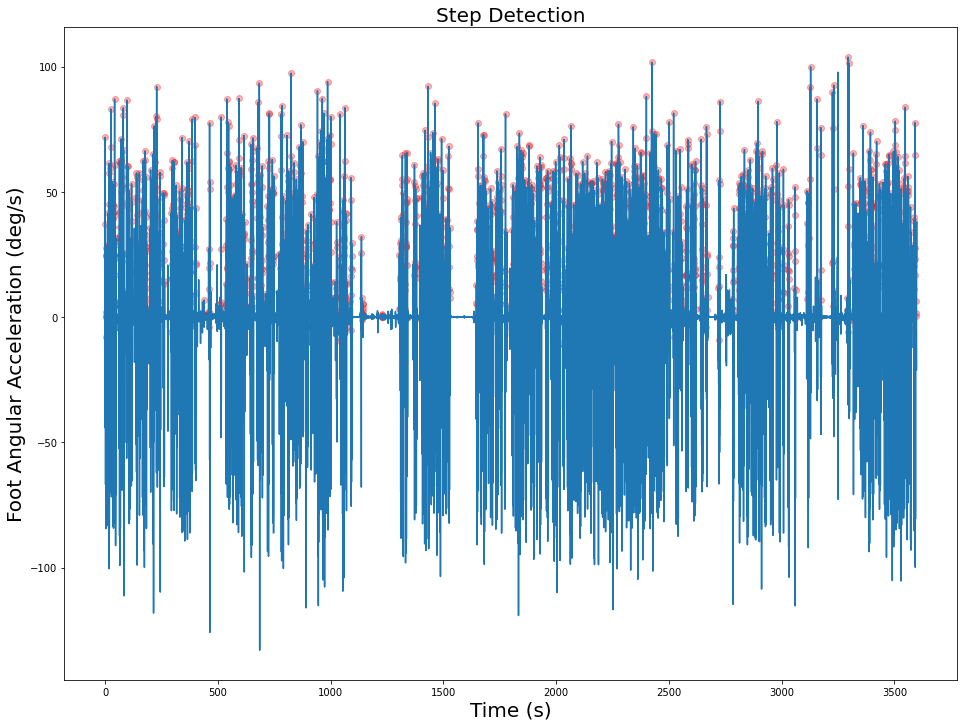

In [36]:
# display the midswing detection results
plt.plot(time, step_signal)
plt.title("Step Detection",fontsize=20)
plt.xlabel("Time (s)",fontsize=20)
plt.ylabel("Foot Angular Acceleration (deg/s)",fontsize=20)
for key in candidate_steps:
    bout_start = final_bouts[key][0]
    #bout_start = 0
    step_arr = candidate_steps[key]
    time_arr = [time[step+bout_start] for step in step_arr]
    step_swing_midpoint = [step_signal[step+bout_start] for step in step_arr]
    plt.scatter(time_arr, step_swing_midpoint, color='red',alpha=0.3)
    #plt.axvline(time_start,color='green')
    #plt.axvline(time_end,color='red') 
figure = plt.gcf()
figure.set_size_inches(16,12)
#out_fig = name + "_TURNS_GyroX_1.png"
#plt.savefig(out_fig, dpi=300)
plt.show()

### Algorithm 2: Use accelerometer data to determine steps

In [ ]:
# modify and run this cell block to change file
processed_file = "dwight_waist100hz_2022-03-29_filtered.csv" # for example purposes, substitute in lines below
name = processed_file.strip(".csv")

In [327]:
accel_df = pd.read_csv(processed_file)
accel_df.head()

,timestamps,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,unix_timestamps
0,2022-04-16T14:00:00.0000000,0.085449,-0.935059,0.282227,1.708984,-40.405276,32.287600,1650117600000
1,2022-04-16T14:00:00.0100000,0.057080,-0.966089,0.267544,-1.061401,-38.230593,32.148439,1650117600010
2,2022-04-16T14:00:00.0200000,0.101455,-0.992813,0.264014,-3.409424,-40.488284,30.401613,1650117600020
3,2022-04-16T14:00:00.0300000,0.144980,-0.999365,0.256294,-2.868042,-41.489871,27.611086,1650117600030
4,2022-04-16T14:00:00.0400000,0.176426,-0.994102,0.238379,1.225586,-39.077151,24.318849,1650117600040


### Filter and Visualize Accelerometer Signal

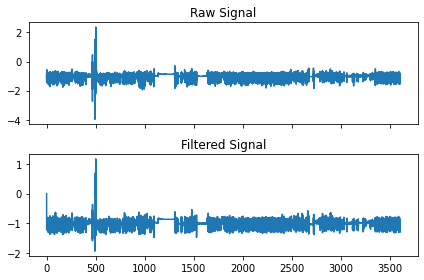

In [329]:
# extract vertical component of linear acceleration
sig = accel_df['accel_y'] # y-axis of waist data appears downshifted???
# apply 20Hz 4th order Butterworth filter
order = 4
filter_freq = 4.0
sampling_freq = 100
sos = signal.butter(N=order, Wn=filter_freq, fs = sampling_freq, 
                     btype='lowpass', analog=False, output="sos")
filtered = signal.sosfilt(sos, sig)
# transform time to 0 and rescale to seconds from ms
time = (accel_df['unix_timestamps'] - min(accel_df['unix_timestamps']))/1000

# plot the raw and filtered signals
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
ax1.plot(time, sig)
ax1.set_title("Raw Signal")
ax2.plot(time, filtered)
ax2.set_title("Filtered Signal")
plt.tight_layout()
plt.show()

### Step Detection
Method adapted from https://ieeexplore.ieee.org/document/7078919 

In [330]:
from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt

# choose signal for step detection
#step_signal = accel_df['y'] # use the raw acceleration data
step_signal = filtered # use the filtered acceleration data

# assume maximum step cadence of 240 steps/min
max_cadence = 240
min_step_separation = 60/max_cadence # in seconds

# candidate steps
candidate_steps = {}

# select all mid-swing (peak pitch angular velocity) candidates from each bout
for (idx, (bout_start, bout_end)) in enumerate(final_bouts):
    peaks = find_peaks(step_signal[bout_start:bout_end], height=None, prominence=0.1, distance=min_step_separation*100)[0] + bout_start
    #peaks = find_peaks_cwt(step_signal[bout_start:bout_end],np.arange(1,10))
    
    # remove bouts with less than 3 steps and fewer than 3 seconds in duration
    if peaks.size > 3:
        candidate_steps[idx] = peaks.tolist()
'''
# detect steps across entire signal
peaks = find_peaks(step_signal, height=None, distance=min_step_separation*100, prominence=0.1)[0]
# assume trophs correspond to peaks of other footstep to find total footsteps
# trophs = find_peaks(-step_signal, height=None, distance=min_step_separation*100, prominence=0.1)[0]
# peaks = np.concatenate((peaks,trophs), 0)
#peaks = find_peaks_cwt(step_signal[bout_start:bout_end],np.arange(1,10))

# remove bouts with less than 3 steps and fewer than 3 seconds in duration
if peaks.size > 3:
    candidate_steps[0] = peaks.tolist()
'''
total_steps = 0
for step_arr in candidate_steps.values():
    print(len(step_arr))
    total_steps += len(step_arr)
print(total_steps)


64
35
13
8
6
6
6
81
6
8
15
8
7
52
7
11
30
31
87
17
7
16
10
21
49
38
99
9
39
8
44
19
115
16
19
6
30
4
8
18
12
5
6
58
6
19
14
27
17
39
11
13
7
19
6
8
10
14
8
17
189
104
30
5
8
4
8
19
14
27
17
12
15
4
7
36
15
20
12
11
12
14
4
5
7
16
7
6
7
4
5
5
9
6
6
34
40
14
80
21
28
6
15
2297


### Visualize Results

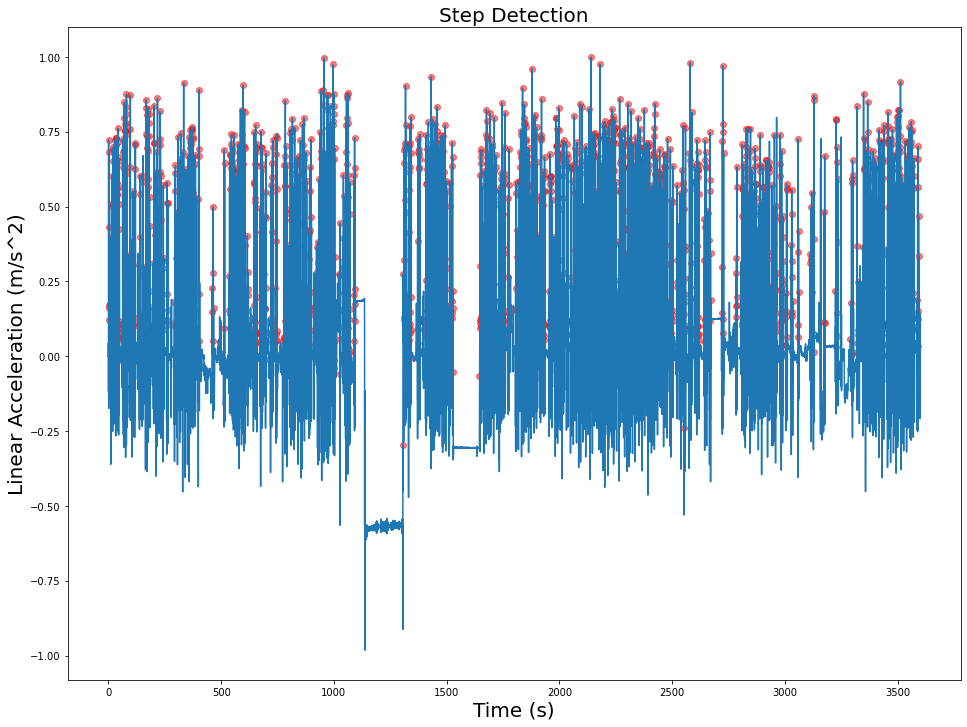

In [46]:
# display the midswing detection results
plt.plot(time, step_signal)
plt.title("Step Detection",fontsize=20)
plt.xlabel("Time (s)",fontsize=20)
plt.ylabel("Linear Acceleration (m/s^2)",fontsize=20)
for key in candidate_steps:
    step_arr = candidate_steps[key]
    time_arr = [time[step] for step in step_arr]
    step_swing_midpoint = [step_signal[step] for step in step_arr]
    plt.scatter(time_arr, step_swing_midpoint, color='red',alpha=0.5)
figure = plt.gcf()
figure.set_size_inches(16,12)
#filename = input("Enter filename ")
#out_fig = name + filename
#plt.savefig(out_fig, dpi=300)
plt.show()

In [47]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import BoxAnnotation

interactive_plot_fname = f"{name}_steps.html"
output_file(filename=interactive_plot_fname, title="Step Detection Graph")

# instantiating the figure object
step_graph = figure(title="Step Detection Graph",
               title_location="above",
               x_axis_label="Time (s)",
               y_axis_label="Linear Acceleration (m/s^2)",
               plot_height=600,
               plot_width=900)
 
# the points to be plotted
x = time
y = filtered
horizontal_motion = accel_df['accel_y']
 
# plotting the 1st line graph
#step_graph.line(x, y, legend_label="Angular Acceleration around Vertical Axis", line_color="blue")
step_graph.line(x, y, line_color="blue")
#step_graph.line(x, horizontal_motion, line_color="green")

# highlight midpoint of swing for all steps
for key in candidate_steps:
    step_arr = candidate_steps[key]
    time_arr = [time[step] for step in step_arr]
    step_swing_midpoint = [step_signal[step] for step in step_arr]
    step_graph.scatter(time_arr, step_swing_midpoint, color='red',alpha=0.5)
 
# displaying the model
show(step_graph)

In [504]:
from bokeh.plotting import save, reset_output
# Save plot to html file
save(step_graph)
reset_output()

# Feature Analysis from Step Data

## Method 1: Determine IC and FC Events Using Gaussian CWT

Number of detected IC events: 636
Number of detected FC events: 868


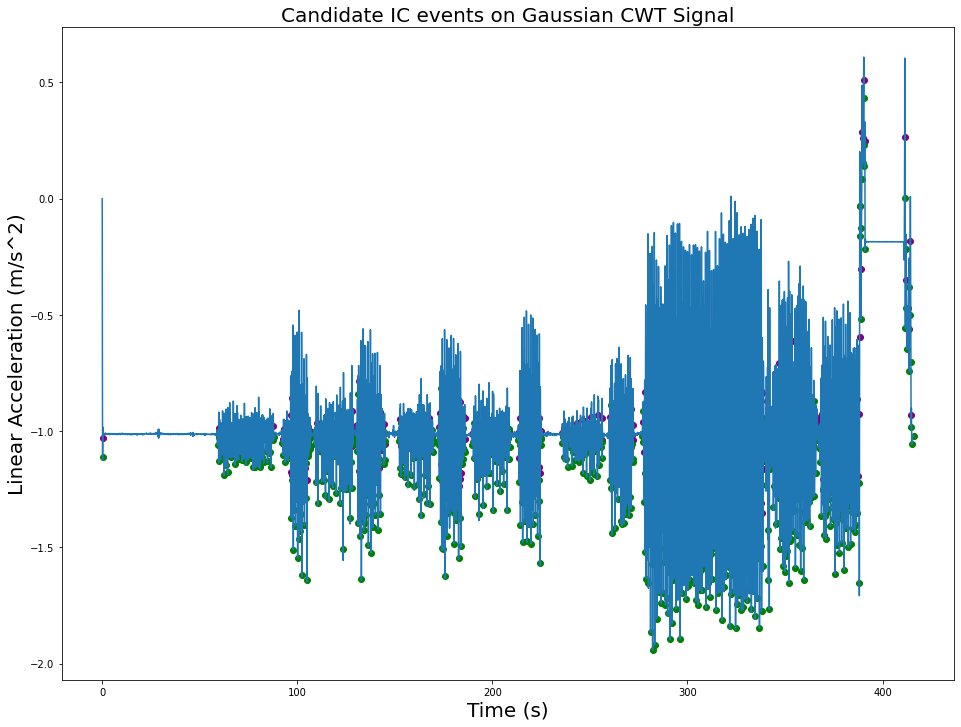

In [216]:
import pywt
import scipy.signal as signal
from scipy.integrate import cumtrapz

# convert chosen wavelet scale to frequency
sampling_rate = 0.01 # 100Hz sampling frequency
wavelet_scale = 5
ic_prominence = 0.2
fc_prominence = 0.3 # higher than IC because the signal is run through CWT twice

# apply gaussian continuous wavelet transform to filtered accelerometer signal
#integrated_signal = cumtrapz(filtered,initial=0)
integrated_signal = filtered
filtered_transformed = pywt.cwt(integrated_signal,wavelet_scale,"gaus1")[0].flatten()

# compute local minima to find potential IC events
ic_event = signal.find_peaks(-filtered_transformed,prominence=ic_prominence)[0]

# find FC events using local maxima of double-filtered and transformed signal
filtered_transformed_cwt = pywt.cwt(filtered_transformed,wavelet_scale,"gaus1")[0].flatten()
fc_event = signal.find_peaks(filtered_transformed_cwt,prominence=fc_prominence)[0]

print(f"Number of detected IC events: {len(ic_event)}")
print(f"Number of detected FC events: {len(fc_event)}")

# display candidate IC events
plt.plot(time, filtered)
plt.title("Candidate IC events on Gaussian CWT Signal",fontsize=20)
plt.xlabel("Time (s)",fontsize=20)
plt.ylabel("Linear Acceleration (m/s^2)",fontsize=20)
IC = []
FC = []
time_arr = [] 
for idx in ic_event:
    IC.append(filtered[idx])
    time_arr.append(time[idx])
plt.scatter(time_arr, IC, color='purple',alpha=1.0)
time_arr = []
for idx in fc_event:
    FC.append(filtered[idx])
    time_arr.append(time[idx])
plt.scatter(time_arr, FC, color='green',alpha=1.0)
figure = plt.gcf()
figure.set_size_inches(16,12)
#filename = input("Enter filename ")
#out_fig = name + filename
#plt.savefig(out_fig, dpi=300)
plt.show()

### Visualize Foot Contact Events

In [50]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import BoxAnnotation

interactive_plot_fname = f"{name}_contact-events.html"
output_file(filename=interactive_plot_fname, title="Foot Contact Events Graph")

# instantiating the figure object
contact_graph = figure(title="Step and IC Detection Graph",
               title_location="above",
               x_axis_label="Time (s)",
               y_axis_label="Linear Acceleration (m/s^2)",
               plot_height=600,
               plot_width=900)
 
# the points to be plotted
x = time
y = filtered
 
# plotting the 1st line graph
#contact_graph.line(x, y, legend_label="Angular Acceleration around Vertical Axis", line_color="blue")
contact_graph.line(x, y, line_color="blue")
#contact_graph.line(x, filtered_transformed, line_color="green", line_dash="dashed")

# highlight IC events
IC = []
time_arr = [] 
for idx in ic_event:
    IC.append(y[idx])
    time_arr.append(time[idx])
contact_graph.scatter(time_arr, IC, color='green',alpha=1.0,legend="Initial Contact (IC)")
# highlight FC events
FC = []
time_arr = []
for idx in fc_event:
    FC.append(y[idx])
    time_arr.append(time[idx])
contact_graph.scatter(time_arr, FC, color='purple',alpha=1.0,legend="Final Contact (FC)")
    
 
# highlight midpoint of swing for all steps
for key in candidate_steps:
    bout_start = final_bouts[key][0]
    #bout_start = 0
    step_arr = candidate_steps[key]
    time_arr = [time[step] for step in step_arr]
    step_swing_midpoint = [y[step] for step in step_arr]
    contact_graph.scatter(time_arr, step_swing_midpoint, color='red',alpha=1.0,legend="Gait Midswing")
    
# displaying the model
show(contact_graph)

In [508]:
# Save plot to html file
save(contact_graph)
reset_output()

### Compute Gait Features using contact events and filtered signal

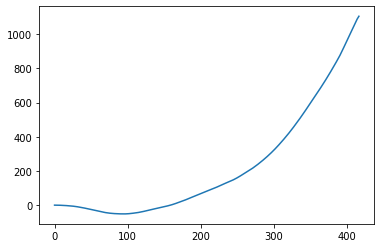

In [50]:
#### USE HORIZONTAL DISPLACEMENT TO DETERMINE FOOT POSITION

# compute vertical position data using double integration of vertical acceleration signal
#sig # low-pass filtered y signal
accel_raw = accel_df['accel_x']

# position = cumtrapz(cumtrapz(accel_y_raw,initial=0),initial=0)

# apply fourth-order zero-lag Butterworth filter at 20.0 Hz
order = 4
filter_freq = 20.0
sampling_freq = 100
sos = signal.butter(N=order, Wn=filter_freq, fs = sampling_freq, 
                     btype='lowpass', analog=False, output="sos")
filtered_acceleration = signal.sosfilt(sos, accel_raw)
# consider median shifting data
filtered_acceleration = filtered_acceleration - np.median(filtered_acceleration)

velocity = cumtrapz(filtered_acceleration,time,initial=0)
position = cumtrapz(velocity, time, initial=0)
'''
# apply fourth-order zero-lag highpass Butterworth filter at 0.1 Hz to avoid integration drift
order = 4
filter_freq = 0.1
sampling_freq = 100
sos = signal.butter(N=order, Wn=filter_freq, fs = sampling_freq, 
                     btype='highpass', analog=False, output="sos")
position = signal.sosfilt(sos, position)
'''
plt.plot(time, position)

Text(0, 0.5, 'Vertical Position Centered About Waist Sensor (m)')

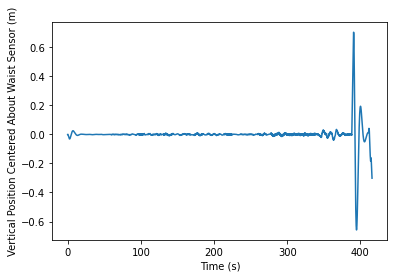

In [51]:
#### USE VERTICAL POSITION TO DETERMINE HORIZONTAL DISPLACEMENT (SEE INVERTED PENDULUM MODEL)

# compute vertical position data using double integration of vertical acceleration signal
#sig # low-pass filtered y signal
accel_raw_y = accel_df['accel_y']

# position = cumtrapz(cumtrapz(accel_y_raw,initial=0),initial=0)

# apply fourth-order zero-lag Butterworth filter at 20.0 Hz
order = 4
filter_freq = 20.0
sampling_freq = 100
sos = signal.butter(N=order, Wn=filter_freq, fs = sampling_freq, 
                     btype='lowpass', analog=False, output="sos")
filtered_acceleration_y = signal.sosfilt(sos, accel_raw_y)
filtered_acceleration_y = filtered_acceleration_y - np.mean(filtered_acceleration_y)

vertical_velocity = cumtrapz(filtered_acceleration_y, time,initial=0)
vertical_position = cumtrapz(vertical_velocity, time, initial=0)

# apply fourth-order zero-lag highpass Butterworth filter at 0.1 Hz to avoid integration drift
order = 4
filter_freq = 0.1
sampling_freq = 100
sos = signal.butter(N=order, Wn=filter_freq, fs = sampling_freq, 
                     btype='highpass', analog=False, output="sos")
vertical_position = signal.sosfilt(sos, vertical_position)

plt.plot(time, vertical_position)
plt.xlabel("Time (s)")
plt.ylabel("Vertical Position Centered About Waist Sensor (m)")

In [52]:
import copy
final_steps = copy.deepcopy(candidate_steps)

# match IC and FC events with detected steps
for bout_idx in final_steps:
    step_arr = final_steps[bout_idx]
    step_idx = 0
    ic_idx = 0
    fc_idx = 0
    number_of_steps = len(step_arr)
    IC_final = np.zeros((number_of_steps,))
    FC_final = np.zeros((number_of_steps,))
    # group IC and FC events with each detected step
    for i in range(0,number_of_steps):
        cur_step = step_arr[i]
        # find closest prior initial contact point
        while ic_idx < len(ic_event) and ic_event[ic_idx] < cur_step:
            ic_idx += 1
        ic_idx -= 1
        # find closest successive final contact point
        while fc_idx < len(fc_event) and fc_event[fc_idx] < cur_step:
            fc_idx += 1
        # add IC and FC events to arrays
        IC_final[i] = ic_event[ic_idx]
        FC_final[i] = fc_event[fc_idx]
        
        # OPTIONAL if IC and FC too far apart, change current step to -1 to indicate it's invalid 
        #print(f"Step: {cur_step}, IC idx: {ic_idx}, IC event: {ic_event[ic_idx]}, FC idx: {fc_idx}, FC event: {fc_event[fc_idx]}")
        
    # add IC and FC events to step dict
    IC_final = IC_final.astype(int)
    FC_final = FC_final.astype(int)
    final_steps[bout_idx] = [step_arr, IC_final, FC_final]

# determine size of output table
table_size = 0
bouts = []
bout_start_time = []
bout_end_time = []
for bout_idx in final_steps:
    step_arr, IC_arr, FC_arr = final_steps[bout_idx]
    number_of_steps = len(step_arr)
    table_size += number_of_steps - 2
    bouts = bouts + [bout_idx]*(number_of_steps-2)
    bout_start_time = bout_start_time + [final_bouts[bout_idx][0]]*(number_of_steps-2)
    bout_end_time = bout_end_time + [final_bouts[bout_idx][1]]*(number_of_steps-2)
    
# initialize output table
feature_df = pd.DataFrame({"Bout":bouts,"Start Time(s)":bout_start_time,"End Time(s)":bout_end_time},
                         columns=["Bout","Start Time(s)","End Time(s)","stride duration","step duration",
                                  "stance duration","swing duration","cadence","step length",
                                  "step length IPM","stride length","stride length IPM","double support (%)",
                                  "gait speed"])   

row = 0
for bout_idx in final_steps:
    step_arr, IC_arr, FC_arr = final_steps[bout_idx]
    step_idx = 0
    number_of_steps = len(step_arr)
    #print(IC_arr)
    for i in range(0,number_of_steps-2):
        cur_step = step_arr[i]
        IC = IC_arr[i]
        FC = FC_arr[i]
        
        # stance time = FC(i+1) - IC(i)
        stance_duration = time[FC_arr[i+1]] - time[IC]
                
        # step duration = IC from one foot to the other
        step_duration = time[IC_arr[i+1]]-time[IC]
                
        # stride duration = IC from one foot to the same foot
        stride_duration = time[IC_arr[i+2]]-time[IC]
        
        # swing time = stride time - stance time
        swing_duration = stride_duration - stance_duration
        
        # calculate cadence = strides per minute
        cadence = 60 / stride_duration
        
        # step length = horizontal distance traveled between IC events
        # step_length = position[IC_arr[i+1]] - position[IC]
        step_length = max(position[IC:IC_arr[i+1]+1]) - min(position[IC:IC_arr[i+1]+1])
        
        # stride length = horizontal distance between IC events of the same foot
        #stride_length = position[IC_arr[i+2]]-position[IC]
        stride_length = step_length + max(position[IC_arr[i+1]:IC_arr[i+2]+1]) - min(position[IC_arr[i+1]:IC_arr[i+2]+1])
        
        # calculate step length using inverted pendulum model - intented for waist data
        l = 0.9
        #h = vertical_position[IC_arr[i+1]] - vertical_position[IC]
        h = max(vertical_position[IC:IC_arr[i+1]+1]) - min(vertical_position[IC:IC_arr[i+1]+1])
        step_length_IPM = 2*np.sqrt(2*l*h - h*h)
        
        # calculate stride length using inverted pendulum model
        #h2 = vertical_position[IC_arr[i+2]] - vertical_position[IC_arr[i+1]]
        h2 = max(vertical_position[IC_arr[i+1]:IC_arr[i+2]+1]) - min(vertical_position[IC_arr[i+1]:IC_arr[i+1]+1])
        stride_length_IPM = 2*np.sqrt(2*l*h2 - h2*h2)+step_length_IPM
        
        # initial double support
        initial_double_support = time[FC] - time[IC]
        
        # terminal double support
        terminal_double_support = time[FC_arr[i+1]] - time[IC_arr[i+1]]
        
        # double support
        if stride_duration != 0:
            double_support = 100*(initial_double_support + terminal_double_support) / stride_duration
        else:
            double_support = 0
            
        # gait speed
        if step_length_IPM <= 0:
            gait_speed = 0
        else:
            gait_speed = step_length_IPM/step_duration
        
        feature_df.loc[row,["stride duration","step duration","stance duration",
                            "swing duration","cadence","step length","stride length",
                            "step length IPM","stride length IPM","double support (%)",
                            "gait speed"]] = [stride_duration,step_duration,stance_duration,
                                              swing_duration,cadence,step_length,stride_length,
                                              step_length_IPM, stride_length_IPM,double_support,
                                              gait_speed]
        row += 1
        #print(f"Stance {stance_duration}, Step {step_duration}, Stride {stride_duration}, Swing {swing_duration}, Cadence {cadence}") 
    
feature_df

KeyError: -1

In [54]:
# save results
feature_df.to_csv(f"{name}_gait-features.csv",index=False)

## Method 2: Compute Features Using GaitPy Algos (MORE CONSISTENT)

In [196]:
from gaitpy.gait import Gaitpy
from gaitpy.util import *
from gaitpy import util

In [331]:
gait_bouts_df = pd.DataFrame()
idx = 0
for (bout_start, bout_end) in final_bouts:
    bout_len = time[bout_end] - time[bout_start]
    bout_row = pd.Series(data={'bout_length':bout_len, 'end_time':accel_df['unix_timestamps'][bout_end], 'start_time':accel_df['unix_timestamps'][bout_start]})
    gait_bouts_df = gait_bouts_df.append(bout_row, ignore_index=True)
    idx+=1
gait_bouts = gait_bouts_df
gait_bouts = gait_bouts.astype({'end_time':'int64','start_time':'int64'})
gait_bouts

,bout_length,end_time,start_time
0,48.95,1650117648950,1650117600000
1,25.36,1650117683560,1650117658200
2,10.79,1650117697150,1650117686360
3,7.64,1650117709700,1650117702060
4,9.06,1650117722060,1650117713000
5,3.17,1650117730400,1650117727230
6,6.61,1650117743170,1650117736560
7,5.08,1650117753560,1650117748480
8,76.87,1650117833770,1650117756900
9,8.93,1650117846970,1650117838040


In [332]:
import warnings

# declare parameters
ic_prom=5
fc_prom=10
down_sample = 50
all_bout_gait_features = pd.DataFrame()
bout_n = 1
sensor_height = 0.90
units = 'g' # g or m/s^2

# Loop through gait bouts
timestamps = accel_df['unix_timestamps']
if units == 'g':
    y_accel = accel_df['accel_y']*9.8
else:
    y_accel = accel_df['accel_y']

# down-sample signal data if necessary
resampled_data, resampled_ts = util._resample_data(y_accel, timestamps, str(1000. / down_sample) + 'ms')
y_accel = pd.Series(resampled_data.y)
timestamps = pd.Series(resampled_ts.astype(np.int64).values // 10**6)

for row_n, bout in gait_bouts.iterrows():
    bout_indices = (timestamps >= bout.start_time) & (timestamps <= bout.end_time)
    bout_data = pd.DataFrame([])
    bout_data['y'] = pd.DataFrame(y_accel.loc[bout_indices].reset_index(drop=True))
    bout_data['ts'] = timestamps.loc[bout_indices].reset_index(drop=True)
    if len(bout_data.y) <= 15:
        warnings.warn('There are too few data points between '+str(bout.start_time)+' and '+str(bout.end_time)+', skipping bout...')
        continue

    # Check the orientation of vertical axis
    window_mu = np.mean(bout_data.y)
    if window_mu < 0:
        pass
    else:
        warnings.warn('Data appears to be flipped between '+str(bout.start_time)+' and '+str(bout.end_time)+', flipping axis...')
        bout_data['y'] = bout_data['y'] * (-1)
    
    # Run CWT Gait Model IC and FC detection
    ic_peaks, fc_peaks = util._cwt(bout_data.y, down_sample, ic_prom, fc_prom)
    
    # Run gait cycle optimization procedure
    pd.options.mode.chained_assignment = None
    optimized_gait = util._optimization(bout_data['ts'], ic_peaks, fc_peaks)
    if optimized_gait.empty or 1 not in list(optimized_gait.Gait_Cycle):
        continue

    # Calculate changes in height of the center of mass
    optimized_gait = util._height_change_com(optimized_gait, bout_data['ts'], bout_data['y'], down_sample)

    # Calculate gait features
    gait_features = util._cwt_feature_extraction(optimized_gait, sensor_height)

    # remove center of mass height and gait cycle boolean columns, remove rows with NAs
    gait_features.dropna(inplace=True)
    gait_features.drop(['CoM_height','Gait_Cycle', 'FC_opp_foot'], axis=1, inplace=True)
    if gait_features.empty:
        continue

    gait_features.insert(0, 'bout_number', bout_n)
    gait_features.insert(1, 'bout_length_sec', bout.bout_length)
    gait_features.insert(2, 'bout_start_time', bout.start_time)
    gait_features.insert(5, 'gait_cycles', len(gait_features))
    all_bout_gait_features = all_bout_gait_features.append(gait_features)

    bout_n += 1
            
all_bout_gait_features.reset_index(drop=True, inplace=True)
all_bout_gait_features.iloc[:,7:] = all_bout_gait_features.iloc[:,7:].round(2)
all_bout_gait_features

d:\evgeni\conda_environments\gaitpy\lib\site-packages\gaitpy-1.6.1-py3.6.egg\gaitpy\util.py:155: RuntimeWarning: invalid value encountered in sqrt
  cwt_features.loc[cwt_features['Gait_Cycle'] == 1, 'step_length'] = 2*(np.sqrt((2*sensor_height*cwt_features.CoM_height)-(cwt_features.CoM_height**2)))


,bout_number,bout_length_sec,bout_start_time,IC,FC,gait_cycles,steps,stride_duration,stride_duration_asymmetry,step_duration,...,single_limb_support_asymmetry,stance,stance_asymmetry,swing,swing_asymmetry,step_length,step_length_asymmetry,stride_length,stride_length_asymmetry,gait_speed
0,1,48.95,1.650118e+12,1650117607960,1650117609040,47,61,1.80,0.10,0.92,...,0.76,1.08,0.04,0.72,0.14,0.20,0.18,0.58,0.12,0.32
1,1,48.95,1.650118e+12,1650117608880,1650117609920,47,61,1.90,0.00,0.88,...,0.14,1.04,0.14,0.86,0.14,0.38,0.06,0.71,0.00,0.37
2,1,48.95,1.650118e+12,1650117609760,1650117610940,47,61,1.90,0.16,1.02,...,0.14,1.18,0.12,0.72,0.04,0.33,0.06,0.71,0.05,0.37
3,1,48.95,1.650118e+12,1650117610780,1650117611840,47,61,1.74,0.20,0.88,...,0.04,1.06,0.04,0.68,0.16,0.38,0.01,0.76,0.07,0.44
4,1,48.95,1.650118e+12,1650117611660,1650117612680,47,61,1.54,0.18,0.86,...,0.16,1.02,0.18,0.52,0.00,0.38,0.08,0.84,0.14,0.54
5,1,48.95,1.650118e+12,1650117612520,1650117613360,47,61,1.36,0.00,0.68,...,0.00,0.84,0.00,0.52,0.00,0.46,0.06,0.97,0.00,0.71
6,1,48.95,1.650118e+12,1650117613200,1650117614040,47,61,1.36,0.02,0.68,...,0.00,0.84,0.00,0.52,0.02,0.51,0.06,0.97,0.02,0.71
7,1,48.95,1.650118e+12,1650117613880,1650117614720,47,61,1.34,0.06,0.68,...,0.02,0.84,0.02,0.50,0.04,0.46,0.07,0.99,0.10,0.74
8,1,48.95,1.650118e+12,1650117614560,1650117615420,47,61,1.40,0.04,0.66,...,0.04,0.86,0.04,0.54,0.00,0.53,0.18,0.88,0.05,0.63
9,1,48.95,1.650118e+12,1650117615220,1650117616120,47,61,1.44,0.14,0.74,...,0.00,0.90,0.08,0.54,0.06,0.35,0.13,0.83,0.01,0.58


In [203]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import BoxAnnotation

# convert IC and FC contact event times to indices for visualization
ic_times = ((all_bout_gait_features['IC']-accel_df['unix_timestamps'][0])/10).astype('int64')
fc_times = ((all_bout_gait_features['FC']-accel_df['unix_timestamps'][0])/10).astype('int64')

interactive_plot_fname = f"{name}_contact-events-gaitpy.html"
output_file(filename=interactive_plot_fname, title="Foot Contact Events Graph")

# instantiating the figure object
gaitpy_contact_graph = figure(title="Contact Events Graph using Gaitpy",
               title_location="above",
               x_axis_label="Time (s)",
               y_axis_label="Linear Acceleration (m/s^2)",
               plot_height=600,
               plot_width=900)
 
# the points to be plotted
x = time
y = filtered
 
# plotting the 1st line graph
#gaitpy_contact_graph.line(x, y, legend_label="Angular Acceleration around Vertical Axis", line_color="blue")
gaitpy_contact_graph.line(x, y, line_color="blue")
#gaitpy_contact_graph.line(x, filtered_transformed, line_color="green", line_dash="dashed")

# highlight IC events
IC = []
time_arr = [] 
for idx in ic_times:
    IC.append(y[idx])
    time_arr.append(time[idx])
gaitpy_contact_graph.scatter(time_arr, IC, color='green',alpha=1.0,legend="Initial Contact (IC)")
# highlight FC events
FC = []
time_arr = []
for idx in fc_times:
    FC.append(y[idx])
    time_arr.append(time[idx])
gaitpy_contact_graph.scatter(time_arr, FC, color='purple',alpha=1.0,legend="Final Contact (FC)")
    
# displaying the model
show(gaitpy_contact_graph)

In [333]:
# save results
all_bout_gait_features.to_csv(f"{name}_gait-features-gaitpy-algos.csv",index=False)

# Feature Analysis
Note that the following code will NOT work for features extracted using Gaitpy or the Gaitpy algorithms. That code can be found in the "Gaitpy Feature Visualization" section.

In [334]:
# load desired data
feature_file = "dwight-data/analysis_4-18-2022/dwight_waist100hz_2022-04-18_filtered_gait-features.csv"
feature_df = pd.read_csv(feature_file, header=0)
feature_df.head()

,Bout,Start Time(s),End Time(s),stride duration,step duration,stance duration,swing duration,cadence,step length,step length IPM,stride length,stride length IPM,double support (%),gait speed
0,0,0,4895,1.01,0.34,0.58,0.43,59.405941,0.011104,0.824475,0.053606,0.824475,51.485149,2.424925
1,0,0,4895,1.43,0.67,1.38,0.05,41.958042,0.042502,1.244621,0.054247,1.244621,66.433566,1.857643
2,0,0,4895,1.77,0.76,0.97,0.80,33.898305,0.011745,1.088238,0.027624,1.720143,51.977401,1.431892
3,0,0,4895,1.47,1.01,1.20,0.27,40.816327,0.015879,0.713679,0.029020,1.616612,27.210884,0.706613
4,0,0,4895,0.72,0.46,0.66,0.06,83.333333,0.013141,0.902933,0.021249,1.659592,54.166667,1.962898


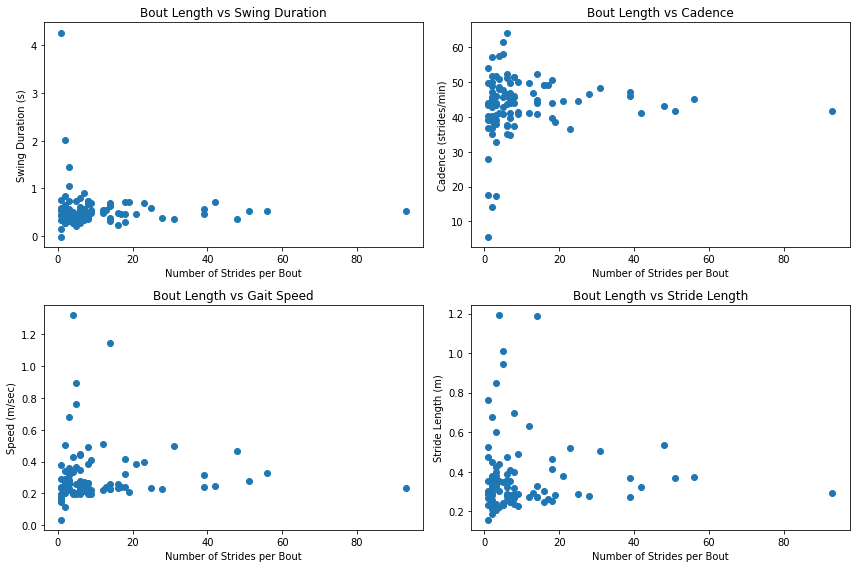

In [335]:
# aggregate features along individual bouts
group_features_by_bouts = feature_df.groupby("Bout")
counts_per_bout = group_features_by_bouts['Bout'].count()
average_value_per_bout = group_features_by_bouts.mean()
strides_per_bout = counts_per_bout//2

# generate plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,sharex=False)
ax1.scatter(strides_per_bout, average_value_per_bout['swing duration'])
ax1.set_title("Bout Length vs Swing Duration")
ax1.set_xlabel("Number of Strides per Bout")
ax1.set_ylabel("Swing Duration (s)")
ax2.scatter(strides_per_bout, average_value_per_bout['cadence'])
ax2.set_title("Bout Length vs Cadence")
ax2.set_xlabel("Number of Strides per Bout")
ax2.set_ylabel("Cadence (strides/min)")
ax3.scatter(strides_per_bout, average_value_per_bout['gait speed'])
ax3.set_title("Bout Length vs Gait Speed")
ax3.set_xlabel("Number of Strides per Bout")
ax3.set_ylabel("Speed (m/sec)")
ax4.scatter(strides_per_bout, average_value_per_bout['stride length IPM'])
ax4.set_title("Bout Length vs Stride Length")
ax4.set_xlabel("Number of Strides per Bout")
ax4.set_ylabel("Stride Length (m)")
fig.set_size_inches(12,8)
plt.tight_layout()
plt.show()

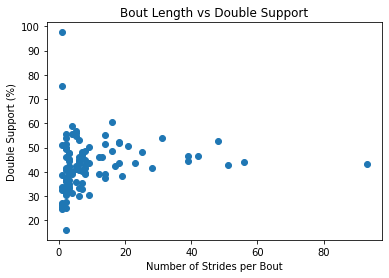

In [336]:
plt.scatter(strides_per_bout, average_value_per_bout['double support (%)'])
plt.title("Bout Length vs Double Support")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Double Support (%)")
plt.show()

In [345]:
# compare against other dataset
feature_file2 = "./sam-data/waist-analysis-no-param-changes/am_waist100hz_2022-03-11_filtered_gait-features.csv"
feature_df2 = pd.read_csv(feature_file2, header=0)
feature_df2.head()

,Bout,Start Time(s),End Time(s),stride duration,step duration,stance duration,swing duration,cadence,step length,step length IPM,stride length,stride length IPM,double support (%),gait speed
0,0,5864,8822,2.71,1.82,2.59,0.12,22.140221,5.024799,1.323369,7.457715,2.290563,60.885609,0.727126
1,0,5864,8822,1.80,0.89,1.30,0.50,33.333333,2.432917,0.967194,4.920078,1.932603,65.555556,1.086735
2,0,5864,8822,2.74,0.91,1.72,1.02,21.897810,2.487162,0.965409,7.473246,2.272321,44.525547,1.060889
3,0,5864,8822,2.80,1.83,2.68,0.12,21.428571,4.986084,1.306912,7.631726,2.296510,59.285714,0.714160
4,0,5864,8822,2.79,0.97,1.79,1.00,21.505376,2.645643,0.989598,7.589820,2.286488,59.856631,1.020204


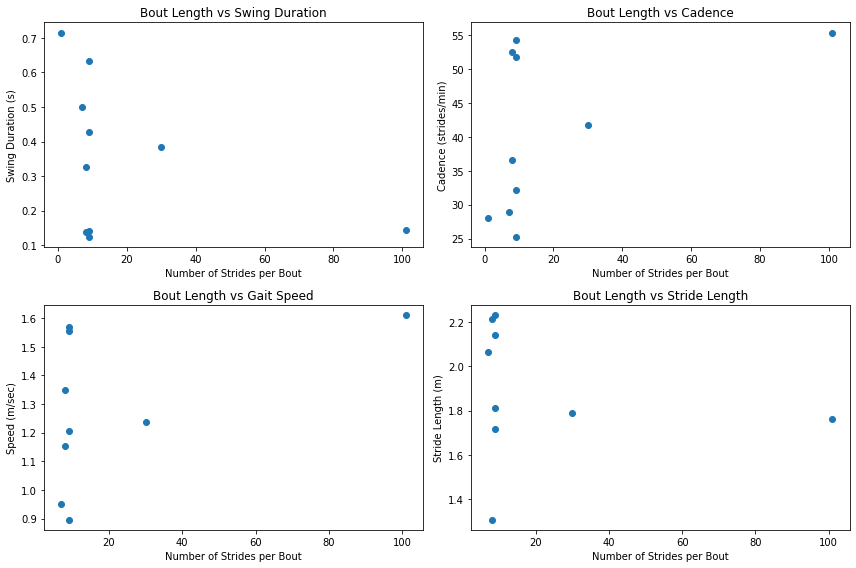

In [346]:
# aggregate features along individual bouts
group_features_by_bouts2 = feature_df2.groupby("Bout")
counts_per_bout2 = group_features_by_bouts2['Bout'].count()
average_value_per_bout2 = group_features_by_bouts2.mean()
strides_per_bout2 = counts_per_bout2//2

# generate plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,sharex=False)
ax1.scatter(strides_per_bout2, average_value_per_bout2['swing duration'])
ax1.set_title("Bout Length vs Swing Duration")
ax1.set_xlabel("Number of Strides per Bout")
ax1.set_ylabel("Swing Duration (s)")
ax2.scatter(strides_per_bout2, average_value_per_bout2['cadence'])
ax2.set_title("Bout Length vs Cadence")
ax2.set_xlabel("Number of Strides per Bout")
ax2.set_ylabel("Cadence (strides/min)")
ax3.scatter(strides_per_bout2, average_value_per_bout2['gait speed'])
ax3.set_title("Bout Length vs Gait Speed")
ax3.set_xlabel("Number of Strides per Bout")
ax3.set_ylabel("Speed (m/sec)")
ax4.scatter(strides_per_bout2, average_value_per_bout2['stride length IPM'])
ax4.set_title("Bout Length vs Stride Length")
ax4.set_xlabel("Number of Strides per Bout")
ax4.set_ylabel("Stride Length (m)")
fig.set_size_inches(12,8)
plt.tight_layout()
plt.show()

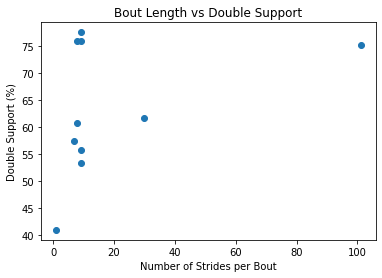

In [347]:
plt.scatter(strides_per_bout2, average_value_per_bout2['double support (%)'])
plt.title("Bout Length vs Double Support")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Double Support (%)")
plt.show()

## Paper Manual Replication
Approximate replication of results from https://www.researchgate.net/figure/Gait-measures-with-a-mean-and-standard-error-of-the-mean-as-a-function-of-bout-length_fig2_344611556 by visual inspection

In [58]:
n_strides_per_bout = np.arange(5,60,5)
stride_axis = [f'{i-2}-{i+2}' for i in n_strides_per_bout]
stride_axis[-1] = "53+"
sample_stride_bins = []
bouts_kept = []
for idx, stride in strides_per_bout.iteritems():
    for bins in n_strides_per_bout:
        # check for large stride lengths
        if stride > 52:
            sample_stride_bins.append('53+')
            bouts_kept.append(idx) 
        elif abs(stride - bins) <= 2:
            sample_stride_bins.append(f'{bins-2}-{bins+2}')
            bouts_kept.append(idx)
            break

# keep only bouts within pre-defined bin ranges
# remove outlier bouts (<3 or >52 strides)
avg_value_per_bout_filtered = average_value_per_bout.loc[bouts_kept]

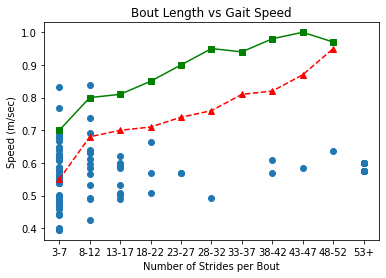

In [59]:
gait_speed_norm = [0.7,0.8,0.81,0.85,0.9,0.95,0.94,0.98,1.0,0.97,np.nan]
gait_speed_pd = [0.55,0.68,0.7,0.71,0.74,0.76,0.81,0.82,0.87,0.95,np.nan]
plt.plot(stride_axis,gait_speed_norm,"s-g")
plt.plot(stride_axis,gait_speed_pd,"^--r")
plt.scatter(sample_stride_bins, avg_value_per_bout_filtered['gait speed'])
plt.title("Bout Length vs Gait Speed")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Speed (m/sec)")
plt.show()

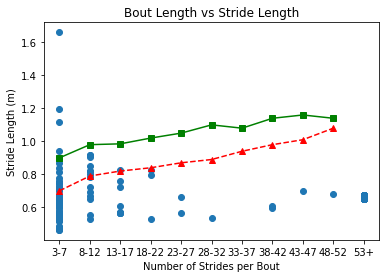

In [60]:
stride_length_norm = [0.9,0.98,0.985,1.02,1.05,1.1,1.08,1.14,1.16,1.14,np.nan]
stride_length_pd = [0.7,0.79,0.82,0.84,0.87,0.89,0.94,0.98,1.01,1.08,np.nan]
plt.plot(stride_axis,stride_length_norm,"s-g")
plt.plot(stride_axis,stride_length_pd,"^--r")
plt.scatter(sample_stride_bins, avg_value_per_bout_filtered['stride length IPM'])
plt.title("Bout Length vs Stride Length")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Stride Length (m)")
plt.show()

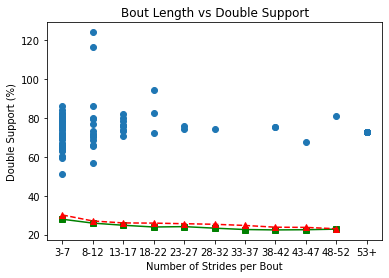

In [61]:
double_support_norm = [27.9,25.9,24.8,23.9,24.1,23.3,22.6,22.4,22.5,22.8,np.nan]
double_support_pd = [30.1,27.0,26.0,25.9,25.6,25.3,24.7,23.8,23.7,23.0,np.nan]
plt.plot(stride_axis,double_support_norm,"s-g")
plt.plot(stride_axis,double_support_pd,"^--r")
plt.scatter(sample_stride_bins, avg_value_per_bout_filtered['double support (%)'])
plt.title("Bout Length vs Double Support")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Double Support (%)")
plt.show()

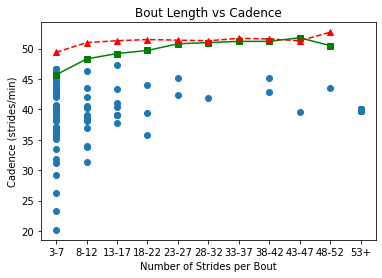

In [62]:
cadence_norm = [45.7,48.3,49.2,49.7,50.8,51.0,51.2,51.2,51.8,50.5,np.nan]
cadence_pd = [49.4,51.0,51.3,51.5,51.4,51.3,51.7,51.6,51.3,52.7,np.nan]
plt.plot(stride_axis,cadence_norm,"s-g")
plt.plot(stride_axis,cadence_pd,"^--r")
plt.scatter(sample_stride_bins, avg_value_per_bout_filtered['cadence'])
plt.title("Bout Length vs Cadence")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Cadence (strides/min)")
plt.show()

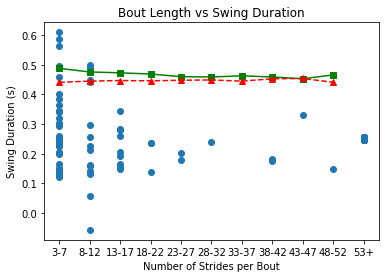

In [63]:
swing_duration_norm = [0.488,0.476,0.473,0.469,0.460,0.459,0.463,0.459,0.453,0.466,np.nan]
swing_duration_pd = [0.441,0.445,0.447,0.446,0.448,0.449,0.445,0.453,0.454,0.441,np.nan]
plt.plot(stride_axis,swing_duration_norm,"s-g")
plt.plot(stride_axis,swing_duration_pd,"^--r")
plt.scatter(sample_stride_bins, avg_value_per_bout_filtered['swing duration'])
plt.title("Bout Length vs Swing Duration")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Swing Duration (s)")
plt.show()

### Remove Outliers

In [97]:
n_strides_per_bout = np.arange(5,60,5)
stride_axis = [f'{i-2}-{i+2}' for i in n_strides_per_bout]
stride_axis[-1] = "53+"
sample_stride_bins = []
bouts_kept = []
for idx, stride in strides_per_bout.iteritems():
    for bins in n_strides_per_bout:
        # check for large stride lengths
        if stride > 52:
            sample_stride_bins.append('53+')
            bouts_kept.append(idx) 
        elif abs(stride - bins) <= 2:
            sample_stride_bins.append(f'{bins-2}-{bins+2}')
            bouts_kept.append(idx)
            break

# keep only bouts within pre-defined bin ranges
# remove outlier bouts (<3 or >52 strides)
avg_value_per_bout_filtered = average_value_per_bout.loc[bouts_kept]

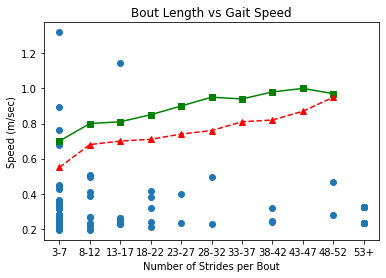

In [98]:
gait_speed_norm = [0.7,0.8,0.81,0.85,0.9,0.95,0.94,0.98,1.0,0.97,np.nan]
gait_speed_pd = [0.55,0.68,0.7,0.71,0.74,0.76,0.81,0.82,0.87,0.95,np.nan]
plt.plot(stride_axis,gait_speed_norm,"s-g")
plt.plot(stride_axis,gait_speed_pd,"^--r")
plt.scatter(sample_stride_bins, avg_value_per_bout_filtered['gait speed'])
plt.title("Bout Length vs Gait Speed")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Speed (m/sec)")
plt.show()

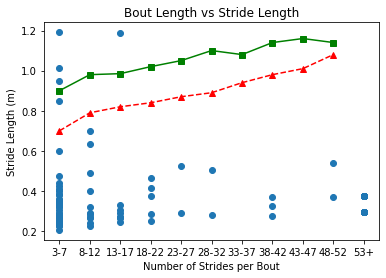

In [99]:
stride_length_norm = [0.9,0.98,0.985,1.02,1.05,1.1,1.08,1.14,1.16,1.14,np.nan]
stride_length_pd = [0.7,0.79,0.82,0.84,0.87,0.89,0.94,0.98,1.01,1.08,np.nan]
plt.plot(stride_axis,stride_length_norm,"s-g")
plt.plot(stride_axis,stride_length_pd,"^--r")
plt.scatter(sample_stride_bins, avg_value_per_bout_filtered['stride length IPM'])
plt.title("Bout Length vs Stride Length")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Stride Length (m)")
plt.show()

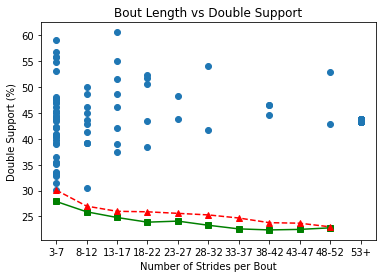

In [100]:
double_support_norm = [27.9,25.9,24.8,23.9,24.1,23.3,22.6,22.4,22.5,22.8,np.nan]
double_support_pd = [30.1,27.0,26.0,25.9,25.6,25.3,24.7,23.8,23.7,23.0,np.nan]
plt.plot(stride_axis,double_support_norm,"s-g")
plt.plot(stride_axis,double_support_pd,"^--r")
plt.scatter(sample_stride_bins, avg_value_per_bout_filtered['double support (%)'])
plt.title("Bout Length vs Double Support")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Double Support (%)")
plt.show()

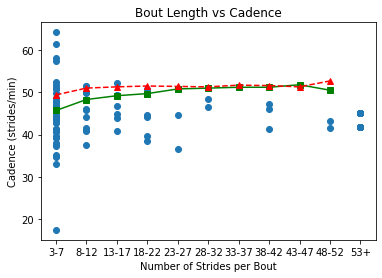

In [101]:
cadence_norm = [45.7,48.3,49.2,49.7,50.8,51.0,51.2,51.2,51.8,50.5,np.nan]
cadence_pd = [49.4,51.0,51.3,51.5,51.4,51.3,51.7,51.6,51.3,52.7,np.nan]
plt.plot(stride_axis,cadence_norm,"s-g")
plt.plot(stride_axis,cadence_pd,"^--r")
plt.scatter(sample_stride_bins, avg_value_per_bout_filtered['cadence'])
plt.title("Bout Length vs Cadence")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Cadence (strides/min)")
plt.show()

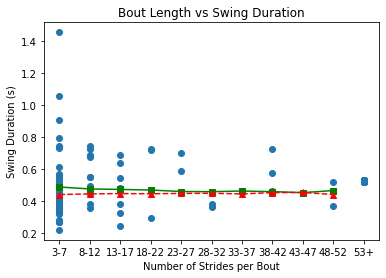

In [102]:
swing_duration_norm = [0.488,0.476,0.473,0.469,0.460,0.459,0.463,0.459,0.453,0.466,np.nan]
swing_duration_pd = [0.441,0.445,0.447,0.446,0.448,0.449,0.445,0.453,0.454,0.441,np.nan]
plt.plot(stride_axis,swing_duration_norm,"s-g")
plt.plot(stride_axis,swing_duration_pd,"^--r")
plt.scatter(sample_stride_bins, avg_value_per_bout_filtered['swing duration'])
plt.title("Bout Length vs Swing Duration")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Swing Duration (s)")
plt.show()

## Gaitpy Feature Visualization

In [337]:
#### FOR GAITPY DATA ONLY

# load desired data
gaitpy_feature_file = "dwight_waist100hz_2022-04-18_filtered_gait-features-gaitpy-algos.csv"
gaitpy_feature_df = pd.read_csv(gaitpy_feature_file, header=0)
gaitpy_feature_df.head()

,bout_number,bout_length_sec,bout_start_time,IC,FC,gait_cycles,steps,stride_duration,stride_duration_asymmetry,step_duration,...,single_limb_support_asymmetry,stance,stance_asymmetry,swing,swing_asymmetry,step_length,step_length_asymmetry,stride_length,stride_length_asymmetry,gait_speed
0,1,48.95,1.650118e+12,1650117607960,1650117609040,47,61,1.80,0.10,0.92,...,0.76,1.08,0.04,0.72,0.14,0.20,0.18,0.58,0.12,0.32
1,1,48.95,1.650118e+12,1650117608880,1650117609920,47,61,1.90,0.00,0.88,...,0.14,1.04,0.14,0.86,0.14,0.38,0.06,0.71,0.00,0.37
2,1,48.95,1.650118e+12,1650117609760,1650117610940,47,61,1.90,0.16,1.02,...,0.14,1.18,0.12,0.72,0.04,0.33,0.06,0.71,0.05,0.37
3,1,48.95,1.650118e+12,1650117610780,1650117611840,47,61,1.74,0.20,0.88,...,0.04,1.06,0.04,0.68,0.16,0.38,0.01,0.76,0.07,0.44
4,1,48.95,1.650118e+12,1650117611660,1650117612680,47,61,1.54,0.18,0.86,...,0.16,1.02,0.18,0.52,0.00,0.38,0.08,0.84,0.14,0.54


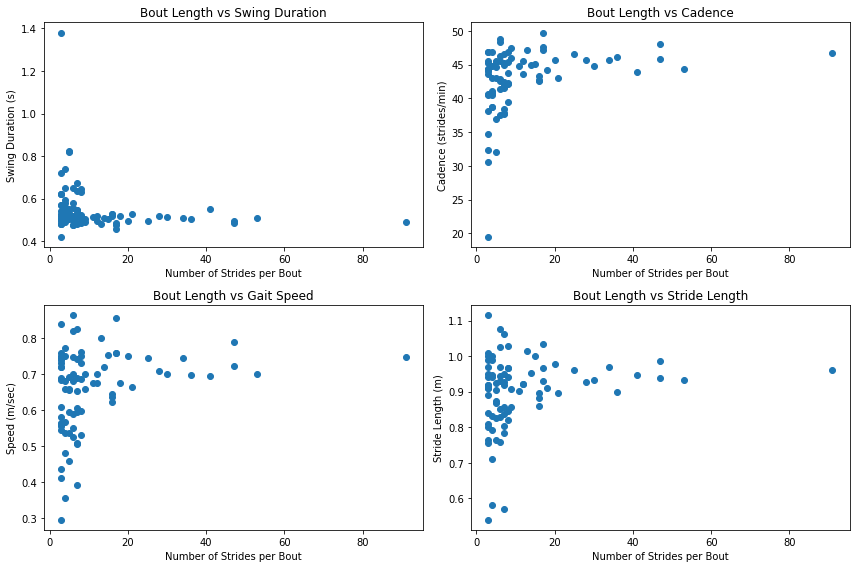

In [338]:
# aggregate features along individual bouts
group_features_by_bouts_gaitpy = gaitpy_feature_df.groupby("bout_number")
average_value_per_bout_gaitpy = group_features_by_bouts_gaitpy.mean()
strides_per_bout_gaitpy = average_value_per_bout_gaitpy['steps']//2

# generate plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,sharex=False)
ax1.scatter(strides_per_bout_gaitpy, average_value_per_bout_gaitpy['swing'])
ax1.set_title("Bout Length vs Swing Duration")
ax1.set_xlabel("Number of Strides per Bout")
ax1.set_ylabel("Swing Duration (s)")
ax2.scatter(strides_per_bout_gaitpy, average_value_per_bout_gaitpy['cadence']/2)
ax2.set_title("Bout Length vs Cadence")
ax2.set_xlabel("Number of Strides per Bout")
ax2.set_ylabel("Cadence (strides/min)")
ax3.scatter(strides_per_bout_gaitpy, average_value_per_bout_gaitpy['gait_speed'])
ax3.set_title("Bout Length vs Gait Speed")
ax3.set_xlabel("Number of Strides per Bout")
ax3.set_ylabel("Speed (m/sec)")
ax4.scatter(strides_per_bout_gaitpy, average_value_per_bout_gaitpy['stride_length'])
ax4.set_title("Bout Length vs Stride Length")
ax4.set_xlabel("Number of Strides per Bout")
ax4.set_ylabel("Stride Length (m)")
fig.set_size_inches(12,8)
plt.tight_layout()
plt.show()

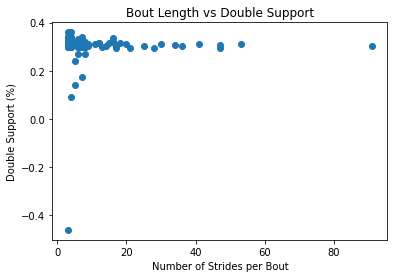

In [339]:
plt.scatter(strides_per_bout_gaitpy, average_value_per_bout_gaitpy['double_support'])
plt.title("Bout Length vs Double Support")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Double Support (%)")
plt.show()

### Compare Against Paper

In [243]:
n_strides_per_bout = np.arange(5,60,5)
stride_axis = [f'{i-2}-{i+2}' for i in n_strides_per_bout]
stride_axis[-1] = "53+"
sample_stride_bins = []
bouts_kept = []
for idx, stride in strides_per_bout_gaitpy.iteritems():
    for bins in n_strides_per_bout:
        # check for large stride lengths
        if stride > 52:
            sample_stride_bins.append('53+')
            bouts_kept.append(idx)
            break
        elif abs(stride - bins) <= 2:
            sample_stride_bins.append(f'{bins-2}-{bins+2}')
            bouts_kept.append(idx)

# keep only bouts within pre-defined bin ranges
# remove outlier bouts (<3 or >52 strides)
avg_value_per_bout_filtered = average_value_per_bout_gaitpy.loc[bouts_kept]

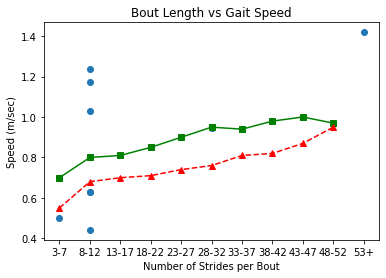

In [286]:
gait_speed_norm = [0.7,0.8,0.81,0.85,0.9,0.95,0.94,0.98,1.0,0.97,np.nan]
gait_speed_pd = [0.55,0.68,0.7,0.71,0.74,0.76,0.81,0.82,0.87,0.95,np.nan]
plt.plot(stride_axis,gait_speed_norm,"s-g")
plt.plot(stride_axis,gait_speed_pd,"^--r")
plt.scatter(sample_stride_bins, avg_value_per_bout_filtered['gait_speed'])
plt.title("Bout Length vs Gait Speed")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Speed (m/sec)")
plt.show()

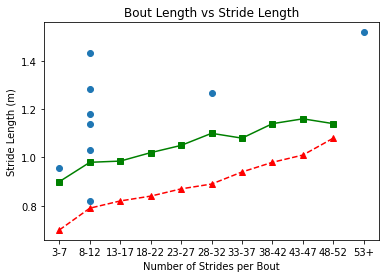

In [285]:
stride_length_norm = [0.9,0.98,0.985,1.02,1.05,1.1,1.08,1.14,1.16,1.14,np.nan]
stride_length_pd = [0.7,0.79,0.82,0.84,0.87,0.89,0.94,0.98,1.01,1.08,np.nan]
plt.plot(stride_axis,stride_length_norm,"s-g")
plt.plot(stride_axis,stride_length_pd,"^--r")
plt.scatter(sample_stride_bins, avg_value_per_bout_filtered['stride_length'])
plt.title("Bout Length vs Stride Length")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Stride Length (m)")
plt.show()

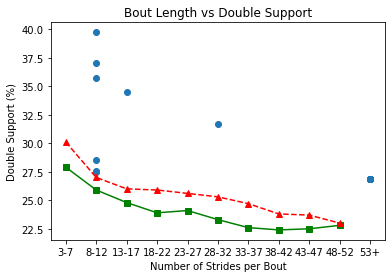

In [213]:
double_support_norm = [27.9,25.9,24.8,23.9,24.1,23.3,22.6,22.4,22.5,22.8,np.nan]
double_support_pd = [30.1,27.0,26.0,25.9,25.6,25.3,24.7,23.8,23.7,23.0,np.nan]
plt.plot(stride_axis,double_support_norm,"s-g")
plt.plot(stride_axis,double_support_pd,"^--r")
plt.scatter(sample_stride_bins, avg_value_per_bout_filtered['double_support']*100)
plt.title("Bout Length vs Double Support")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Double Support (%)")
plt.show()

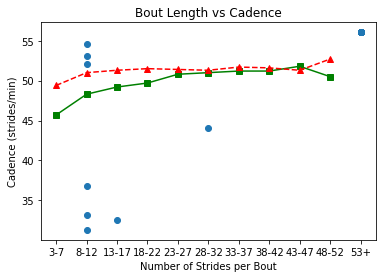

In [214]:
cadence_norm = [45.7,48.3,49.2,49.7,50.8,51.0,51.2,51.2,51.8,50.5,np.nan]
cadence_pd = [49.4,51.0,51.3,51.5,51.4,51.3,51.7,51.6,51.3,52.7,np.nan]
plt.plot(stride_axis,cadence_norm,"s-g")
plt.plot(stride_axis,cadence_pd,"^--r")
plt.scatter(sample_stride_bins, avg_value_per_bout_filtered['cadence']/2)
plt.title("Bout Length vs Cadence")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Cadence (strides/min)")
plt.show()

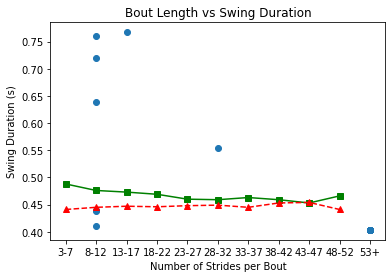

In [215]:
swing_duration_norm = [0.488,0.476,0.473,0.469,0.460,0.459,0.463,0.459,0.453,0.466,np.nan]
swing_duration_pd = [0.441,0.445,0.447,0.446,0.448,0.449,0.445,0.453,0.454,0.441,np.nan]
plt.plot(stride_axis,swing_duration_norm,"s-g")
plt.plot(stride_axis,swing_duration_pd,"^--r")
plt.scatter(sample_stride_bins, avg_value_per_bout_filtered['swing'])
plt.title("Bout Length vs Swing Duration")
plt.xlabel("Number of Strides per Bout")
plt.ylabel("Swing Duration (s)")
plt.show()

### Compare Against Paper AND Method 1 of Feature Extraction

In [348]:
n_strides_per_bout = np.arange(5,60,5)
stride_axis = [f'{i-2}-{i+2}' for i in n_strides_per_bout]
stride_axis[-1] = "53+"
sample_stride_bins_gaitpy = []
bouts_kept = []
for idx, stride in strides_per_bout_gaitpy.iteritems():
    for bins in n_strides_per_bout:
        # check for large stride lengths
        if stride > 52:
            sample_stride_bins_gaitpy.append('53+')
            bouts_kept.append(idx)
            break
        elif abs(stride - bins) <= 2:
            sample_stride_bins_gaitpy.append(f'{bins-2}-{bins+2}')
            bouts_kept.append(idx)

# keep only bouts within pre-defined bin ranges
# remove outlier bouts (<3 or >52 strides)
avg_value_per_bout_filtered = average_value_per_bout_gaitpy.loc[bouts_kept]


n_strides_per_bout = np.arange(5,60,5)
stride_axis = [f'{i-2}-{i+2}' for i in n_strides_per_bout]
stride_axis[-1] = "53+"
sample_stride_bins = []
bouts_kept = []
for idx, stride in strides_per_bout.iteritems():
    for bins in n_strides_per_bout:
        # check for large stride lengths
        if stride > 52:
            sample_stride_bins.append('53+')
            bouts_kept.append(idx)
            break
        elif abs(stride - bins) <= 2:
            sample_stride_bins.append(f'{bins-2}-{bins+2}')
            bouts_kept.append(idx)

# keep only bouts within pre-defined bin ranges
# remove outlier bouts (<3 or >52 strides)
average_value_per_bout = average_value_per_bout.loc[bouts_kept]

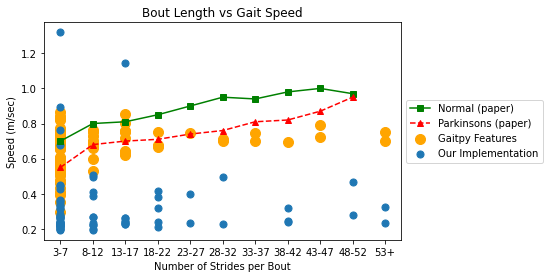

In [349]:
gait_speed_norm = [0.7,0.8,0.81,0.85,0.9,0.95,0.94,0.98,1.0,0.97,np.nan]
gait_speed_pd = [0.55,0.68,0.7,0.71,0.74,0.76,0.81,0.82,0.87,0.95,np.nan]
ax = plt.subplot(111)
ax.plot(stride_axis,gait_speed_norm,"s-g")
ax.plot(stride_axis,gait_speed_pd,"^--r")
ax.scatter(sample_stride_bins_gaitpy, avg_value_per_bout_filtered['gait_speed'], s = 100, color='orange')
ax.scatter(sample_stride_bins, average_value_per_bout['gait speed'], s = 50)
ax.set_title("Bout Length vs Gait Speed")
ax.set_xlabel("Number of Strides per Bout")
ax.set_ylabel("Speed (m/sec)")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['Normal (paper)','Parkinsons (paper)','Gaitpy Features','Our Implementation'], loc='center left', bbox_to_anchor=(1, 0.5))
figure = plt.gcf()
figure.set_size_inches(8,4)
plt.show()

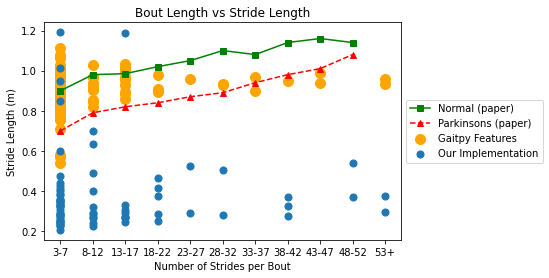

In [350]:
stride_length_norm = [0.9,0.98,0.985,1.02,1.05,1.1,1.08,1.14,1.16,1.14,np.nan]
stride_length_pd = [0.7,0.79,0.82,0.84,0.87,0.89,0.94,0.98,1.01,1.08,np.nan]
ax = plt.subplot(111)
ax.plot(stride_axis,stride_length_norm,"s-g")
ax.plot(stride_axis,stride_length_pd,"^--r")
ax.scatter(sample_stride_bins_gaitpy, avg_value_per_bout_filtered['stride_length'], s = 100, color='orange')
ax.scatter(sample_stride_bins, average_value_per_bout['stride length IPM'], s = 50)
ax.set_title("Bout Length vs Stride Length")
ax.set_xlabel("Number of Strides per Bout")
ax.set_ylabel("Stride Length (m)")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['Normal (paper)','Parkinsons (paper)','Gaitpy Features','Our Implementation'], loc='center left', bbox_to_anchor=(1, 0.5))
figure = plt.gcf()
figure.set_size_inches(8,4)
plt.show()

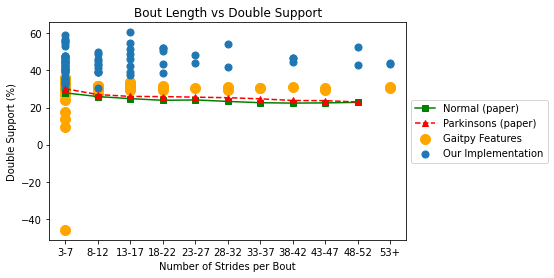

In [351]:
double_support_norm = [27.9,25.9,24.8,23.9,24.1,23.3,22.6,22.4,22.5,22.8,np.nan]
double_support_pd = [30.1,27.0,26.0,25.9,25.6,25.3,24.7,23.8,23.7,23.0,np.nan]
ax = plt.subplot(111)
ax.plot(stride_axis,double_support_norm,"s-g")
ax.plot(stride_axis,double_support_pd,"^--r")
ax.scatter(sample_stride_bins_gaitpy, avg_value_per_bout_filtered['double_support']*100, s=100, color='orange')
ax.scatter(sample_stride_bins, average_value_per_bout['double support (%)'], s = 50)
ax.set_title("Bout Length vs Double Support")
ax.set_xlabel("Number of Strides per Bout")
ax.set_ylabel("Double Support (%)")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['Normal (paper)','Parkinsons (paper)','Gaitpy Features','Our Implementation'], loc='center left', bbox_to_anchor=(1, 0.5))
figure = plt.gcf()
figure.set_size_inches(8,4)
plt.show()

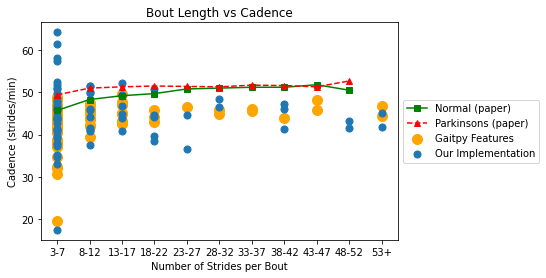

In [352]:
cadence_norm = [45.7,48.3,49.2,49.7,50.8,51.0,51.2,51.2,51.8,50.5,np.nan]
cadence_pd = [49.4,51.0,51.3,51.5,51.4,51.3,51.7,51.6,51.3,52.7,np.nan]
ax = plt.subplot(111)
ax.plot(stride_axis,cadence_norm,"s-g")
ax.plot(stride_axis,cadence_pd,"^--r")
ax.scatter(sample_stride_bins_gaitpy, avg_value_per_bout_filtered['cadence']/2, s=100,color='orange')
ax.scatter(sample_stride_bins, average_value_per_bout['cadence'], s = 50)
ax.set_title("Bout Length vs Cadence")
ax.set_xlabel("Number of Strides per Bout")
ax.set_ylabel("Cadence (strides/min)")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['Normal (paper)','Parkinsons (paper)','Gaitpy Features','Our Implementation'], loc='center left', bbox_to_anchor=(1, 0.5))
figure = plt.gcf()
figure.set_size_inches(8,4)
plt.show()

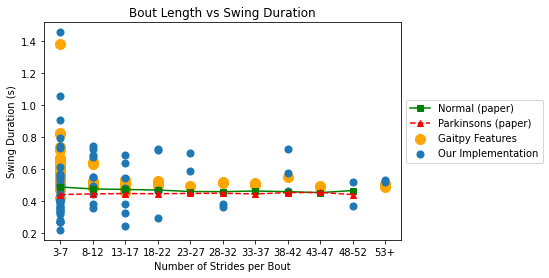

In [353]:
swing_duration_norm = [0.488,0.476,0.473,0.469,0.460,0.459,0.463,0.459,0.453,0.466,np.nan]
swing_duration_pd = [0.441,0.445,0.447,0.446,0.448,0.449,0.445,0.453,0.454,0.441,np.nan]
ax = plt.subplot(111)
ax.plot(stride_axis,swing_duration_norm,"s-g")
ax.plot(stride_axis,swing_duration_pd,"^--r")
ax.scatter(sample_stride_bins_gaitpy, avg_value_per_bout_filtered['swing'], s=100, color='orange')
ax.scatter(sample_stride_bins, average_value_per_bout['swing duration'], s = 50)
ax.set_title("Bout Length vs Swing Duration")
ax.set_xlabel("Number of Strides per Bout")
ax.set_ylabel("Swing Duration (s)")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['Normal (paper)','Parkinsons (paper)','Gaitpy Features','Our Implementation'], loc='center left', bbox_to_anchor=(1, 0.5))
figure = plt.gcf()
figure.set_size_inches(8,4)
plt.show()